# Content-Based Music Recommendation
Name: jiayi zhou, zid: z5542720

# Part 1 Topic Classification

In [55]:
# import modules
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns

In [56]:
# load the data
datapath = "../dataset.tsv"
df = pd.read_csv(datapath, sep="\t")
df.head(5)

,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB


In [58]:
def get_doc_df(df):
    doc_list = []
    for _, row in df.iterrows():
        doc_list.append(" ".join(list(row.astype(str))[:-1])) # concate the col
    df['doc'] = doc_list
    df = df.iloc[:,-2:] # drop the redundent
    return df

df = get_doc_df(df)
df.head(5)

,topic,doc
0,dark,loving the not real lake 2016 rock awake know ...
1,lifestyle,incubus into the summer 2019 rock shouldn summ...
2,sadness,reignwolf hardcore 2016 blues lose deep catch ...
3,sadness,tedeschi trucks band anyhow 2016 blues run bit...
4,dark,lukas nelson and promise of the real if i star...


## Part 1.1
- For regex filtering, I edit the original regex formula keep the punctuation character, and also filter tokens which length is 1 or less.
- For train-test split, I replace it with 'StratifiedKFold' which can also keep the ratio with topic in any subset and augmenting the generalization ability.

### preprocess the data

In [59]:
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_text(text):
    text = re.sub(r"\s+", " ", text)
    
    # text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    # tokens = [ps.stem(word) for word in tokens]
    text = re.sub(r"[^\w\s\.\'\"\-]", '', text)
    return ' '.join(tokens)

# Apply preprocessing to each document
df['doc'] = df['doc'].apply(preprocess_text)
# save as the csv, we could easily check the output
df.to_csv('processed_text.csv', sep="\t")
# use the standart settings
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['doc'])
print(X.shape)
y = df['topic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1342)

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
acc_bnb = bnb.score(X_test, y_test)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
acc_mnb = mnb.score(X_test, y_test)

print(f"BNB Accuracy: {acc_bnb:.4f}", end="\t")
print(f"MNB Accuracy: {acc_mnb:.4f}")

[nltk_data] Downloading package stopwords to /Users/jiayi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/jiayi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(1500, 9940)
BNB Accuracy: 0.5467	MNB Accuracy: 0.8356


## Part 1.2
The below cell was used to test the ability for BNB and MNB, and we find the "best" in overall situations.

## Part 1.3
In below cell, I apply 'StratifiedKFold' with fold 6, and use the random_seed that we can reproduce the outcomes.<br>
And in same subset, we initial BNB and MNB, that we could compare the diff with them.

### Tradeoffs
For MNB model, we can see the outcomes in fold1 and flod3 are almost the same in accuracy both around 0.76. And there are more differences in precision and recall rate. In fold3 we got slightly increasing in presicion but more decreasing in recall, in generall with increasing on precision and more decreasing in reall for the same model.

show the tables below

In [60]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=1342)

results = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold + 1}\t\tAccuracy\tPrecision\tRecall\t\tF1-score")
    X_train, X_test = X[train_index, :], X[test_index, :] # type: ignore
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit BNB model
    bnb = BernoulliNB()
    bnb.fit(X_train, y_train)
    # calculate metrics
    y_pred = bnb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"BNB Outcomes:\t{acc:.4f}\t\t{pre:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")
    results.append([fold+1, "BNB", acc, pre, rec, f1])

    # fit MNB model
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    # calculate metrics
    y_pred = mnb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"MNB Outcomes:\t{acc:.4f}\t\t{pre:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")
    results.append([fold+1,"MNB", acc, pre, rec, f1])
    
    print("-" * 80)

Fold: 1		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.5560		0.4231		0.4061		0.3698
MNB Outcomes:	0.7800		0.7176		0.6963		0.6980
--------------------------------------------------------------------------------
Fold: 2		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.5480		0.3838		0.3960		0.3499
MNB Outcomes:	0.8160		0.8111		0.7278		0.7453
--------------------------------------------------------------------------------
Fold: 3		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.5240		0.3332		0.3742		0.3286
MNB Outcomes:	0.7840		0.7310		0.6743		0.6823
--------------------------------------------------------------------------------
Fold: 4		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.4800		0.3282		0.3543		0.3112
MNB Outcomes:	0.8120		0.8228		0.7992		0.8082
--------------------------------------------------------------------------------
Fold: 5		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.5160		0.3865		0.3774		0.3402
MNB Outcomes:	0.8000		0.7770		0.7129		0.7317
-

convert the outputs as the graph

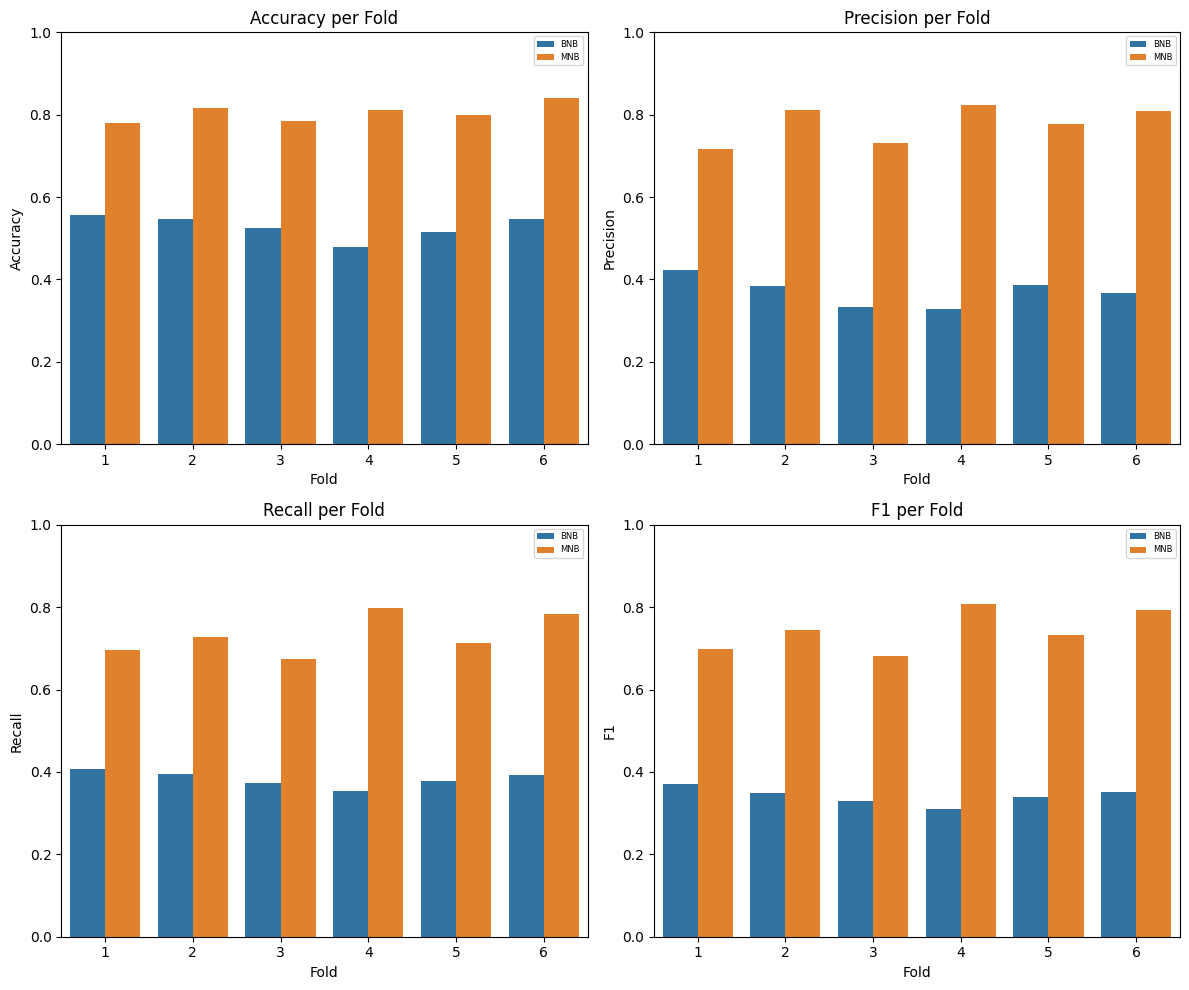

In [61]:
def compared_plot(results_list):
    df = pd.DataFrame(results_list, columns=['Fold', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.barplot(data=df, x='Fold', y=metric, hue='Model', ax=ax)
        ax.set_title(f'{metric} per Fold')
        ax.set_ylim(0, 1.0)
        ax.set_ylabel(metric)
        ax.legend(title=None, loc='best', fontsize=6, title_fontsize=8)

    plt.tight_layout()
    plt.show()


compared_plot(results_list=results)



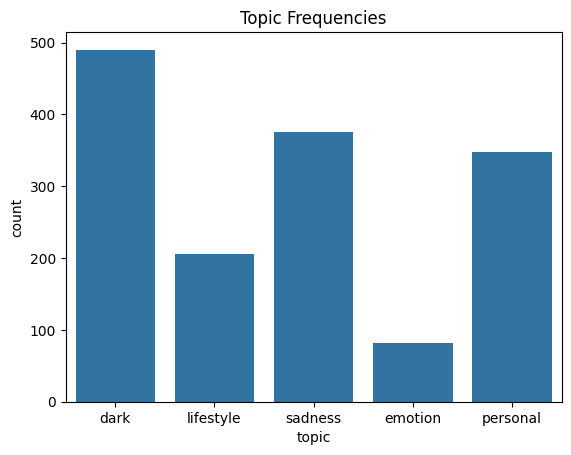

In [62]:
sns.countplot(
    data=df,
    x="topic"
)
plt.title("Topic Frequencies")
plt.show()

In [63]:
feature_nums = range(5, 1500, 20)
results = []

for N in tqdm(feature_nums):
    # top N features
    vectorizer = CountVectorizer(max_features=N)
    X = vectorizer.fit_transform(df['doc'])
    
    bnb_scores, mnb_scores = [], []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)): # type: ignore
        X_train, X_test = X[train_index, :], X[test_index, :] # type: ignore
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fit BNB model
        bnb = BernoulliNB()
        bnb.fit(X_train, y_train)
        y_pred = bnb.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        bnb_scores.append([acc, pre, rec, f1])

        # fit MNB model
        mnb = MultinomialNB()
        mnb.fit(X_train, y_train)
        y_pred = mnb.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        mnb_scores.append([acc, pre, rec, f1])

    bnb_avg = np.mean(bnb_scores, axis=0)
    mnb_avg = np.mean(mnb_scores, axis=0)
    results.append([N, "BNB"] + bnb_avg.tolist())
    results.append([N, "MNB"] + mnb_avg.tolist())

    results.append((N, acc_bnb, acc_mnb))

  0%|          | 0/75 [00:00<?, ?it/s]

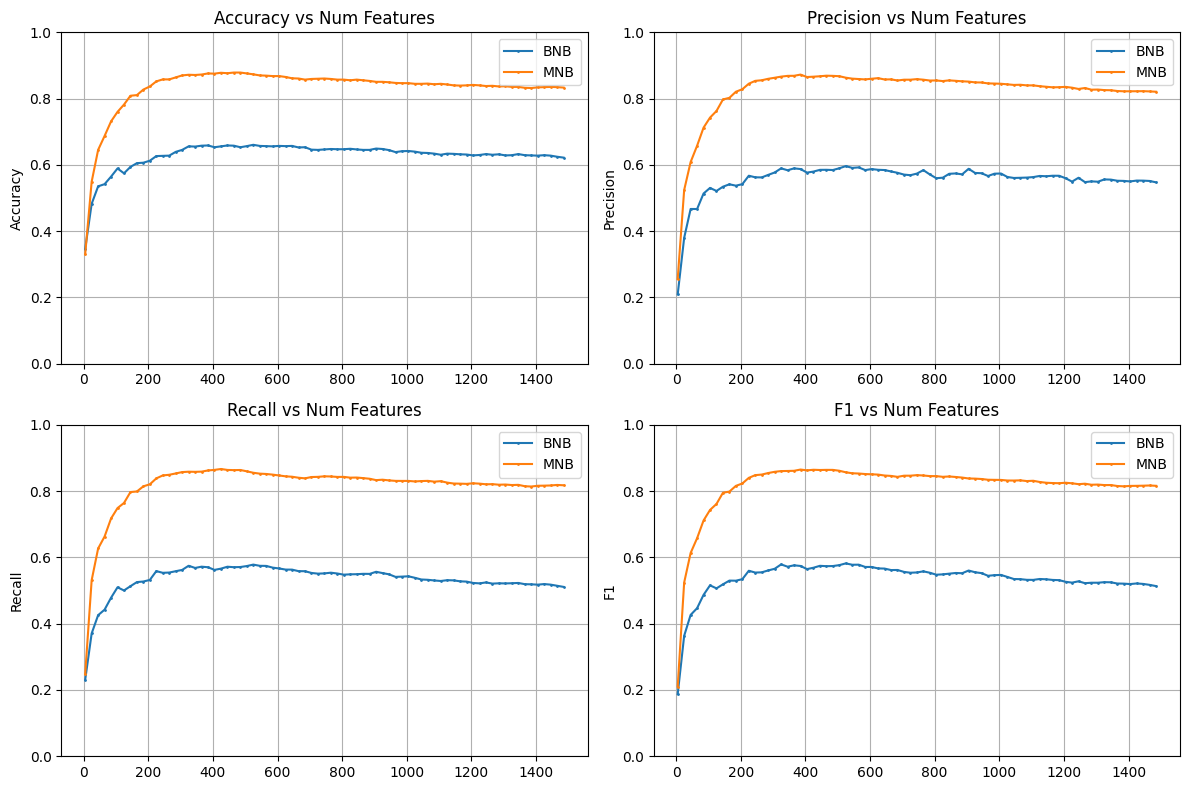

In [64]:
def compared_num_features_plot(results_list):

    df = pd.DataFrame(results_list, columns=["Num_Features", "Model", "Accuracy", "Precision", "Recall", "F1"])

    metrics = ["Accuracy", "Precision", "Recall", "F1"]
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        for model in ["BNB", "MNB"]:
            subset = df[df['Model'] == model]
            plt.plot(subset["Num_Features"], subset[metric], marker='o', label=model, markersize=1)
        plt.title(f"{metric} vs Num Features")
        plt.ylabel(metric)
        plt.ylim(0, 1.0)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

compared_num_features_plot(results_list=results)

## Part 1.5
### Part 1.5.1 LogisticRegression
Logistic Regression is a classic machine learning method that models the relationship between input features and class labels. In this assignment, I use TF-IDF scores of song lyrics as input features to predict the topic of each song. As a well-established classification algorithm, logistic regression performs well in text classification tasks and serves as a strong method for this problem.
### Part 1.5.2 Parameters choices
For parameter optimization, I used Grid Search to find the best combination of hyperparameters for the logistic regression model. This method systematically explores different values to improve classification performance and ensures that the model is well-tuned for the dataset.
### Part 1.5.3 Outcome hypothesis
I believe logistic regression should outperform both BNB and MNB. This is because the model leverages TF-IDF representations, which capture the importance of words more effectively than raw counts. Furthermore, logistic regression generally has stronger expressive power and flexibility compared to the default settings of the Naive Bayes models.

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

best_vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.7, ngram_range=(1,2), sublinear_tf=True, norm=None)
X_tfidf = best_vectorizer.fit_transform(df['doc'])
y = df['topic']

param_grid = {
    'C': np.logspace(-3, 1, 10),
    'max_iter': [100, 150],
    'tol': [2e-3, 3e-3, 1e-4],
    # 'penalty': ['l1', 'l2'],
    'solver': ['liblinear'], 
    'class_weight': ['balanced']
}


clf = LogisticRegression(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=6, scoring='f1_macro', n_jobs=8, verbose=1)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.15, random_state=42)
grid_search.fit(X_train, y_train)


print("Best params:", grid_search.best_params_)
print("Best F1-macro:", grid_search.best_score_)
clf = grid_search.best_estimator_


Fitting 6 folds for each of 60 candidates, totalling 360 fits
Best params: {'C': np.float64(0.007742636826811269), 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.002}
Best F1-macro: 0.8272159529361139


In [67]:
# Predict the categories of the test set
y_pred = clf.predict(X_test)

# Print accuracy and classification report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8488888888888889
              precision    recall  f1-score   support

        dark       0.89      0.92      0.90        77
     emotion       0.83      0.71      0.77         7
   lifestyle       0.76      0.63      0.69        30
    personal       0.83      0.85      0.84        59
     sadness       0.85      0.88      0.87        52

    accuracy                           0.85       225
   macro avg       0.83      0.80      0.81       225
weighted avg       0.85      0.85      0.85       225



In [68]:
vectorizer = CountVectorizer(max_features=400)
X = vectorizer.fit_transform(df['doc'])
y = df['topic']

In [69]:
results = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold + 1}\t\tAccuracy\tPrecision\tRecall\t\tF1-score")
    X_train, X_test = X[train_index, :], X[test_index, :] # type: ignore
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit BNB model
    bnb = BernoulliNB()
    bnb.fit(X_train, y_train)
    y_pred = bnb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print(f"BNB Outcomes:\t{acc:.4f}\t\t{pre:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")
    results.append([fold+1, "BNB", acc, pre, rec, f1])

    # fit MNB model
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print(f"MNB Outcomes:\t{acc:.4f}\t\t{pre:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")
    results.append([fold+1,"MNB", acc, pre, rec, f1])

    # fit third model
    _, test_set = X_tfidf[train_index, :], X_tfidf[test_index, :] # type: ignore
    # clf.fit(X_train, y_train)
    y_pred = clf.predict(test_set)
    pre = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print(f"LR Outcomes:\t{acc:.4f}\t\t{pre:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")
    results.append([fold+1, "Logistic Regression", acc, pre, rec, f1])
    
    print("-" * 80)

Fold: 1		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.6800		0.5666		0.5601		0.5609
MNB Outcomes:	0.8720		0.8510		0.8673		0.8583
LR Outcomes:	0.8720		0.9875		0.9885		0.9880
--------------------------------------------------------------------------------
Fold: 2		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.6560		0.5848		0.5708		0.5696
MNB Outcomes:	0.8720		0.8581		0.8288		0.8410
LR Outcomes:	0.8720		0.9669		0.9565		0.9612
--------------------------------------------------------------------------------
Fold: 3		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.6400		0.5992		0.5617		0.5733
MNB Outcomes:	0.8520		0.8326		0.8364		0.8335
LR Outcomes:	0.8520		0.9734		0.9691		0.9712
--------------------------------------------------------------------------------
Fold: 4		Accuracy	Precision	Recall		F1-score
BNB Outcomes:	0.6400		0.5618		0.5569		0.5574
MNB Outcomes:	0.8760		0.8656		0.8965		0.8766
LR Outcomes:	0.8760		0.9619		0.9696		0.9654
-----------------------------------------

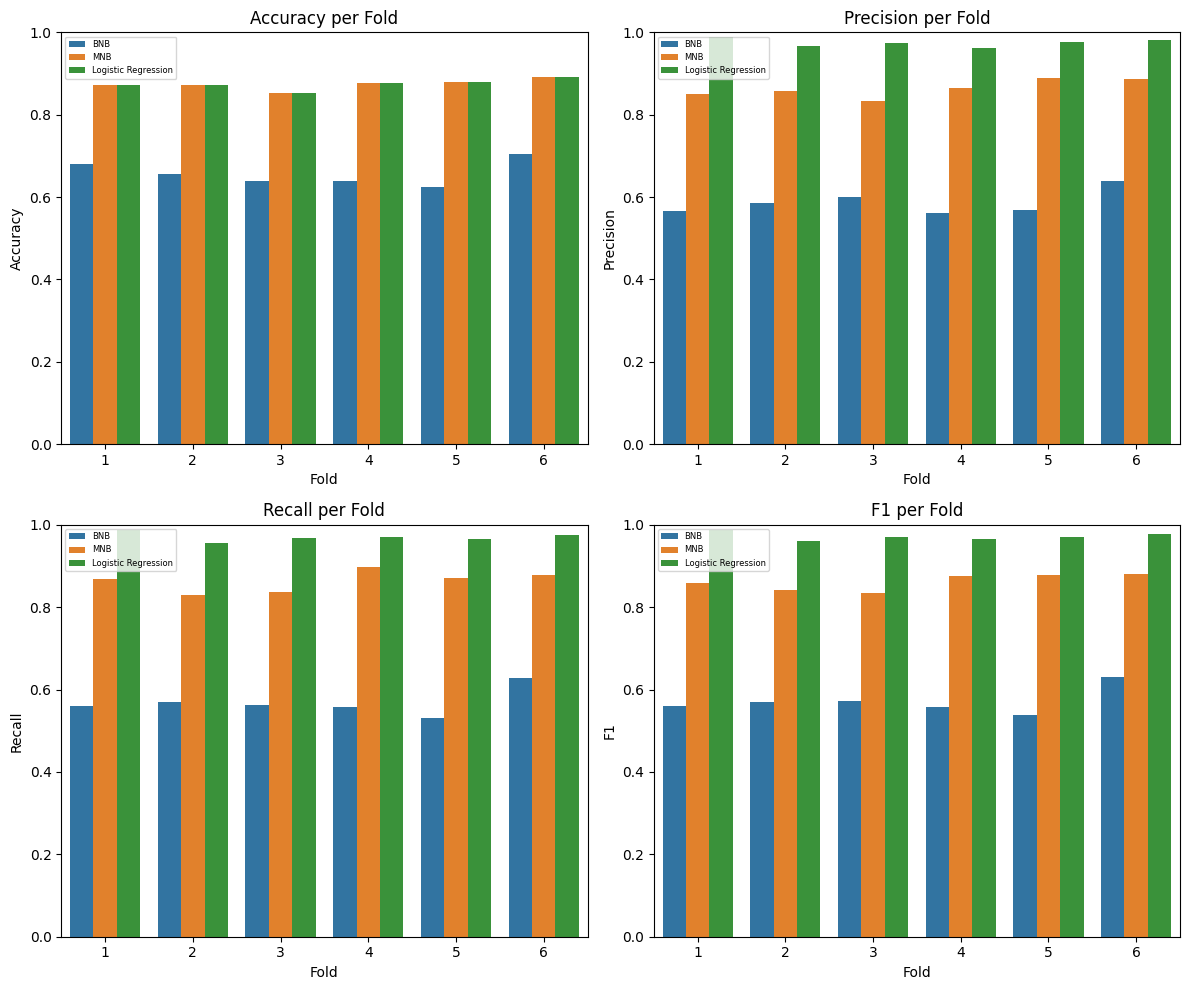

In [70]:
compared_plot(results_list=results)

# Part 2. Recommendation Methods


## Part 2.1

In [92]:
from sklearn.metrics.pairwise import cosine_similarity

# prepare the data using in this part
df_4week = df[:1000].copy()


df_4week['pred_topic'] = clf.predict(best_vectorizer.transform(df_4week['doc']))
train_df = df_4week.iloc[:750].reset_index(drop=True)
test_df = df_4week.iloc[750:].reset_index(drop=True)

df_4week.sample(5)

,topic,doc,pred_topic
116,personal,terence blanchard jackie gets 2017 jazz whooaa...,personal
842,dark,hiphop tamizha vaadi nee vaa 2018 hip hop stan...,dark
267,personal,aaron lewis story life 2016 country watch flam...,personal
775,lifestyle,marcus miller 7-t 's 2018 jazz right super fai...,lifestyle
174,sadness,weeknd hurt 2018 pop know relationship enemy s...,sadness


### Part 2.1.1 calculate tf-idf matrix by topic in training df

In [93]:
def get_topic_matrix(df, use_predict=True):
    results = {}
    # group by predict topic
    if use_predict:
        df_groupby_topic = df.groupby('pred_topic')
    else:
        df_groupby_topic = df.groupby('topic')
    # for each group we generate a new tfidf matrix
    for topic, group in df_groupby_topic:
        results[topic] = best_vectorizer.transform(group['doc'])
    return results

train_topic_to_matrix = get_topic_matrix(df=train_df)


### Part 2.1.2 read the user keywords and find the interested songs

In [94]:
def get_matched_songs_id(df, user_keywords):
    matched_idx = {}
    for idx, row in df.iterrows():
        # match the topic keywords first
        keywords = user_keywords.get(row['pred_topic'])
        if not keywords:
            continue
        if any(word in row['doc'] for word in keywords): # if any keywords in doc, we thinks these two matched
            if row['pred_topic'] not in matched_idx:
                matched_idx[row['pred_topic']] = []
            matched_idx[row['pred_topic']].append(idx) # append idx to dict
    return matched_idx

def read_user_file(path:str):
    # read the user file, get keywords into attribute
    df = pd.read_csv(path, sep="\t")
    return {row['topic']:row['keywords'].split(sep=",") for _, row in df.iterrows()}

user_path1 = "../user1.tsv"
user_path2 = "../user2.tsv"

user1 = read_user_file(path=user_path1)
user2 = read_user_file(path=user_path2)

matched_songs1 = get_matched_songs_id(train_df, user1)
matched_songs2 = get_matched_songs_id(train_df, user2)

print(matched_songs1, matched_songs2, sep="\n")

{'dark': [0, 8, 37, 52, 64, 68, 71, 72, 79, 81, 83, 88, 97, 110, 113, 119, 129, 139, 145, 153, 155, 162, 163, 178, 182, 203, 208, 209, 214, 218, 228, 240, 252, 256, 264, 265, 266, 278, 293, 298, 301, 307, 317, 333, 351, 362, 363, 365, 368, 400, 408, 416, 425, 454, 471, 472, 478, 485, 488, 515, 540, 543, 556, 560, 571, 574, 576, 588, 592, 601, 603, 613, 614, 643, 654, 660, 662, 669, 681, 686, 688, 690, 691, 722, 723, 749], 'emotion': [5, 18, 33, 34, 56, 85, 229, 248, 284, 318, 327, 330, 364, 374, 403, 412, 423, 448, 484, 513, 541, 593, 620, 724, 728, 734, 741], 'personal': [10, 12, 14, 23, 25, 27, 41, 50, 66, 77, 93, 96, 99, 101, 102, 111, 126, 130, 138, 141, 168, 180, 184, 185, 188, 194, 195, 198, 200, 210, 220, 221, 223, 225, 235, 238, 244, 249, 251, 258, 260, 267, 272, 283, 286, 294, 302, 310, 313, 319, 320, 324, 346, 367, 372, 376, 377, 378, 381, 389, 391, 397, 420, 426, 433, 434, 435, 444, 446, 450, 452, 462, 468, 490, 497, 498, 499, 504, 524, 532, 535, 542, 553, 565, 568, 572, 575

### Part 2.1.3 calculate the scores for each topic, print the top 20 words in vec

In [112]:
def aggregate_matched_songsbytopic(df, matched_idx):
    # this fun will concatenate all the songs user interested and return as a huge doc
    res = {}
    for topic, idx_list in matched_idx.items():
        cur_df = df.iloc[idx_list]
        res[topic] = " ".join(cur_df['doc'].tolist())
    return res

def get_user_profile(songs_by_topic):
    user_profile = {}
    for topic, songs in songs_by_topic.items():
        # we use vectorizer calculate the tfidf value
        user_profile[topic] = best_vectorizer.transform([songs])
    # the results represent for each topic we got the vectorize user profile 
    return user_profile

def gen_top_N_words(user_profile, N=20):
    
    print(f"The Top {N} words for each topic are: ")
    for topic, matrix in user_profile.items():
        feature_name = best_vectorizer.get_feature_names_out() # get word name
        word_scores = np.asarray(matrix.sum(axis=0)).flatten()
        top_idxs = word_scores.argsort()[::-1]
        top_words = [feature_name[i] for i in top_idxs[:N]]
        print(f"{topic}: {' '.join(top_words)}") # type: ignore

print("The output for user1: ")
songs_by_topic = aggregate_matched_songsbytopic(df=train_df, matched_idx=matched_songs1)
user_profile = get_user_profile(songs_by_topic)
gen_top_N_words(user_profile)
print("-"*120)
print("The output for user2: ")
songs_by_topic = aggregate_matched_songsbytopic(df=train_df, matched_idx=matched_songs2)
user_profile = get_user_profile(songs_by_topic)
gen_top_N_words(user_profile)
print("-"*120)
print("The output for user3: ")
user3_keywords = {
    "dark": ["shadow", "blade", "rage", "blood", "doom"],
    "sadness": ["broken", "sorrow", "goodbye", "silence", "loneliness"],
    "personal": ["journey", "self", "purpose", "vision", "freedom"],
    "lifestyle": ["weekend", "fashion", "drinks", "crowd", "escape"],
    "emotion": ["touch", "passion", "heartbeat", "embrace", "desire"]
}
get_matched_songs_id(df=train_df, user_keywords=user3_keywords)
songs_by_topic = aggregate_matched_songsbytopic(df=train_df, matched_idx=matched_songs1)
user_profile = get_user_profile(songs_by_topic)
gen_top_N_words(user_profile)
print("-"*120)

The output for user1: 
The Top 20 words for each topic are: 
dark: blood blood come fall wall come na fight steady fight fight follow follow brain brain slave lalalalala paint color silent riot woah wing woah woah sword grind grind fight
emotion: touch touch good feelin video good feel visions good good feel good feelin good vibe hold hold touch lips lips lovin miss miss feelin sunrise light light luck feel feel kiss kiss
personal: ordinary life life ordinary beat teach ordinary promise promise lord lord american dream heartbreak change world vibe teach life life place need live forever na live change life life live american thank live live
lifestyle: strangers strangers spoil night closer closer na home night spoil strangers spoil lalala telephone tonight tonight ring ring depression summer depression long long closer sing sing snake tire songs rhythm
sadness: club cry know mean steal cry cry tear thrill heat mean music blame true smile lift regret darling fire thousand beg wear
-----

## Part 2.2

In [139]:
def recommend_topN(user_keywords, N=50):

    matched_idxs = get_matched_songs_id(df=train_df, user_keywords=user_keywords)
    songs_by_topic = aggregate_matched_songsbytopic(df=train_df, matched_idx=matched_idxs)
    user_profile = get_user_profile(songs_by_topic)
    
    matched_dict_in_test = get_matched_songs_id(df=test_df, user_keywords=user_keywords)
    matched_idxs_in_test = set(id for id_list in matched_dict_in_test.values() for id in id_list )

    similarity_list = []
    
    for _, row in test_df.iterrows():
        if row['pred_topic'] in user_profile:
            sim = cosine_similarity(
                train_topic_to_matrix[row['pred_topic']],
                best_vectorizer.transform([row['doc']])
            )
            similarity_list.append(sim.max())
        else:
            similarity_list.append(0)
        
    
    test_df['similarity'] = similarity_list

    # sort by similarity
    top_N_idx = np.argsort(similarity_list)[-N:]
    top_N_idx = top_N_idx[::-1]
    
    acc = 0
    for idx in top_N_idx:
        if idx in matched_idxs_in_test:
            acc += 1

    precision = acc / N
    recall = acc / len(matched_idxs_in_test)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    print(f"Precision@{N}: {precision:.4f}", end="\t")
    print(f"Recall@{N}: {recall:.4f}", end="\t")
    print(f"F1-score@{N}: {f1:.4f}")

recommend_topN(user1)
print("-"*80)
recommend_topN(user2)
print("-"*80)
recommend_topN(user3_keywords)
print("-"*80)

Precision@50: 0.3200	Recall@50: 0.1739	F1-score@50: 0.2254
--------------------------------------------------------------------------------
Precision@50: 0.1200	Recall@50: 0.6000	F1-score@50: 0.2000
--------------------------------------------------------------------------------
Precision@50: 0.0400	Recall@50: 0.0667	F1-score@50: 0.0500
--------------------------------------------------------------------------------


In [ ]:
def sample_3weeks(df, N=30):
    res = []

    for i in range(3):
        start = i * 250
        end = start + 250
        week_df = df.iloc[start:end, :]
        sampled = week_df.sample(n=N, random_state=42)
        res.append(sampled)
    
    return pd.concat(res).reset_index(drop=True)

temp_df = sample_3weeks(df)
temp_df.to_csv("real_profile_wait.csv", index=False)

In [ ]:
real_user_profile = pd.read_csv('real_profile.csv')
matched_idx_dict = {}

for topic, group in real_user_profile.groupby('topic'):
    for idx, row in group.iterrows():
        if row['like'] == 1:
            if topic not in matched_idx_dict:
                matched_idx_dict[topic] = [idx]
            else:
                matched_idx_dict[topic].append(idx)

songs_by_topic = aggregate_matched_songsbytopic(df=real_user_profile, matched_idx=matched_idx_dict)
user_profile = get_user_profile(songs_by_topic)
N = 30

similarity_list = []

for _, row in test_df.iterrows():
    if row['pred_topic'] in user_profile:
        sim = cosine_similarity(
            train_topic_to_matrix[row['pred_topic']],
            best_vectorizer.transform([row['doc']])
        )
        similarity_list.append(sim.max())
    else:
        similarity_list.append(0)
    

test_df['similarity'] = similarity_list

# sort by similarity
top_N_idx = np.argsort(similarity_list)[-N:]
top_N_idx = top_N_idx[::-1]

top_df = test_df.iloc[top_N_idx]
top_df.to_csv("recomended_songs.csv", index=False)


In [149]:
temp_df = pd.read_csv("recomended_songs_eval.csv")
precision = temp_df['like'].sum() / N
print(f"Precision@{N}: {precision:.4f}")

Precision@30: 0.4333
